# Dataset 1 - Regression

## Import Libraries 

In [2]:
import train_test
import ABC_train_test
import regressionDataset
import network
import statsModel
import performanceMetrics
import dataset
import sanityChecks
import torch 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import norm
from torch.utils.data import Dataset,DataLoader 
from torch import nn
import warnings
warnings.filterwarnings('ignore')

## Dataset

Generate a random regression problem

Parameters: 
1. No of sample points 
2. No of features = n 

$Y = 1 + \beta_1 x_1 + \beta_2 x_2 + \beta_2 x_3 + ... + \beta_n x_n + N(0,\sigma)$ where $\sigma = 0.1$

In [3]:
n_features = 10
sample_size = 100

In [4]:
X,Y = regressionDataset.regression_data(sample_size,n_features)

         X1        X2        X3        X4        X5        X6        X7  \
0 -1.357507 -0.348393  1.541600  0.505982  0.211457  0.739421 -1.604222   
1 -0.295727  0.601346 -0.077790 -1.259783 -0.237440 -0.980869  1.248129   
2 -1.504681 -0.756887  1.544697 -0.509864  0.757723 -1.844043  2.077543   
3 -0.600340 -0.468546  0.074294 -0.109077 -0.766341  0.218289  0.848241   
4 -0.576524 -0.374200 -2.607005  1.445408 -1.354766 -1.089425 -1.228998   

         X8        X9       X10           Y  
0 -0.642981 -1.021520 -0.434965  -75.357395  
1 -0.208844  1.520325 -1.321731 -131.843758  
2 -0.449985 -1.829198 -1.001360 -111.504937  
3  0.376150  0.508403 -0.138126   73.154448  
4 -0.056313  0.017075 -1.813719 -400.386893  


## Stats Model

No handles with labels found to put in legend.


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.247e+07
Date:                Wed, 06 Oct 2021   Prob (F-statistic):          1.27e-292
Time:                        19:31:27   Log-Likelihood:                 627.02
No. Observations:                 100   AIC:                            -1232.
Df Residuals:                      89   BIC:                            -1203.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -7.98e-17   4.85e-05  -1.64e-12      1.0

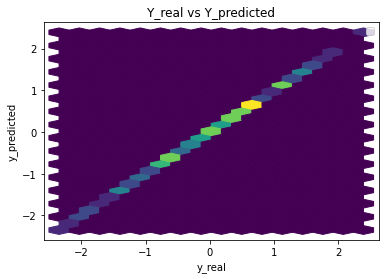

Performance Metrics
Mean Squared Error: 2.0955437503283265e-07
Mean Absolute Error: 0.0003667436925090932
Manhattan distance: 0.03667436925090932
Euclidean distance: 0.004577710945798485


In [5]:
[coeff,y_pred] = statsModel.statsModel(X,Y)

# Generator and Discriminator Networks 

In [6]:
#Discriminator Parameters 
hidden_nodes = 25 
#ABC Generator Parameters
mean = 1 
variance = 0.001

**GAN Generator**

In [7]:
class Generator(nn.Module):

  def __init__(self,n_input):
    super().__init__()
    self.output = nn.Linear(n_input,1)

  def forward(self, x):
    x = self.output(x)
    return x 

**GAN Discriminator**

In [8]:
class Discriminator(nn.Module):

  def __init__(self,n_input,n_hidden):

    super().__init__()
    self.hidden = nn.Linear(n_input,n_hidden)
    self.output = nn.Linear(n_hidden,1)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.hidden(x)
    x = self.relu(x)
    x = self.output(x)
    return x 

**ABC Generator**

The ABC generator is defined as follows:

$Y = 1 + \beta_1 x_1 + \beta_2 x_2 + \beta_2 x_3 + ... + \beta_n x_n + N(0,\sigma)$ where $\sigma = 0.1$ 

$\beta_i \sim N(0,\sigma^{*})$ when $\mu = 0$ else

$\beta_i \sim N(\beta_i^{*},\sigma^{*})$ where $\beta_i^{*}s$ are coefficients obtained from stats model

Parameters : $\mu$ and $\sigma^{*}$

$\sigma^{*}$ takes the values 0.01,0.1 and 1

In [9]:
def ABC_pre_generator(x_batch,coeff,variance,mean,device):

  coeff_len = len(coeff)

  if mean == 0:
    weights = np.random.normal(0,variance,size=(coeff_len,1))
    weights = torch.from_numpy(weights).reshape(coeff_len,1)
  else:
    weights = []
    for i in range(coeff_len):
      weights.append(np.random.normal(coeff[i],variance))
    weights = torch.tensor(weights).reshape(coeff_len,1)
    
  y_abc =  torch.matmul(x_batch,weights.float())
  gen_input = torch.cat((x_batch,y_abc),dim = 1).to(device)
  return gen_input 

# GAN Model

In [10]:
real_dataset = dataset.CustomDataset(X,Y)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
generator = Generator(n_features+2)
discriminator = Discriminator(n_features+2,hidden_nodes)

criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(generator.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.01, betas=(0.5, 0.999))

In [12]:
n_epochs = 5000
batch_size = sample_size//2

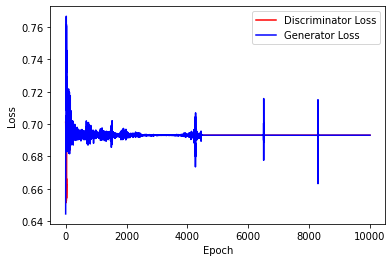

In [13]:
train_test.training_GAN(discriminator,generator,disc_opt,gen_opt,real_dataset,batch_size, n_epochs,criterion,device)

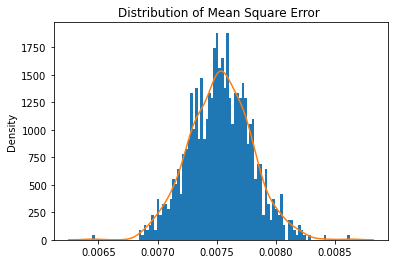

Mean Square Error: 0.007532061794448202


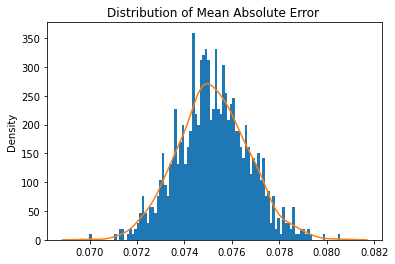

Mean Absolute Error: 0.07519753438172862


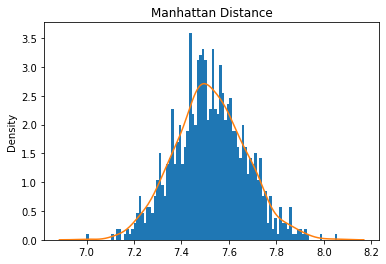

Mean Manhattan Distance: 7.519753438172862


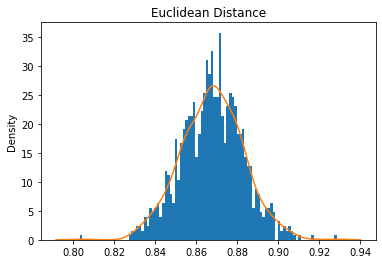

Mean Euclidean Distance: 7.519753438172862


In [14]:
train_test.test_generator(generator,real_dataset,device)

# ABC GAN Model

#### Training the network

In [21]:
gen = Generator(n_features+2)
disc = Discriminator(n_features+2,hidden_nodes)

criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.01, betas=(0.5, 0.999))

In [22]:
n_epoch_abc = 2000
batch_size = sample_size//2

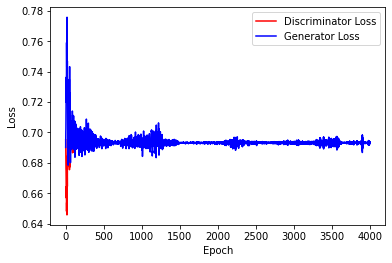

In [23]:
ABC_train_test.training_GAN(disc, gen,disc_opt,gen_opt,real_dataset, batch_size, n_epoch_abc,criterion,coeff,mean,variance,device)

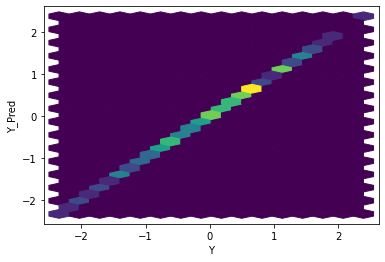

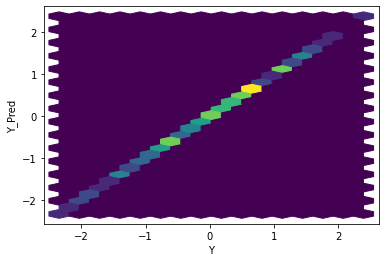

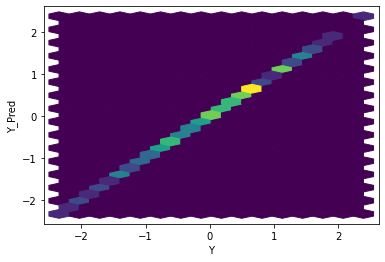

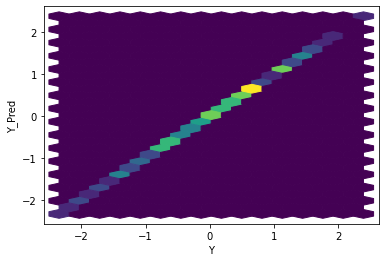

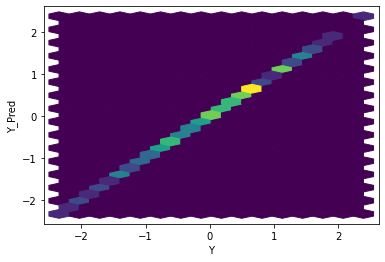

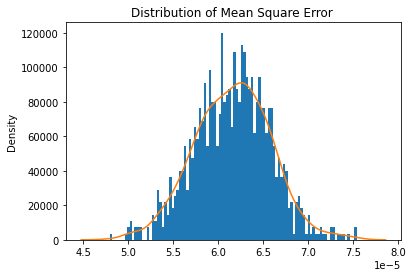

Mean Square Error: 6.1566749552807e-05


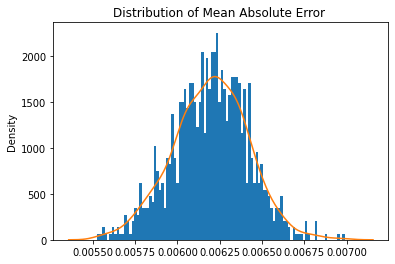

Mean Absolute Error: 0.006196070901416242
Mean Manhattan Distance: 0.6196070901416242


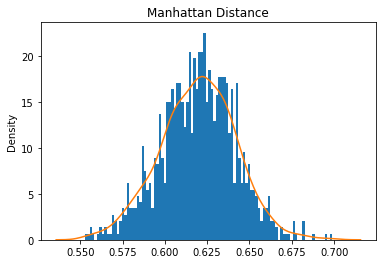

Mean Euclidean Distance: 0.07841825516417134


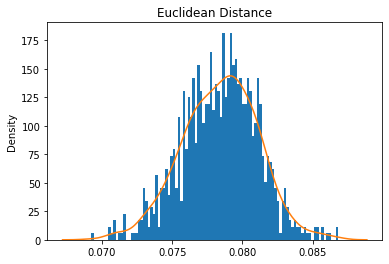

In [24]:
ABC_train_test.test_generator(gen,real_dataset,coeff,mean,variance,device)

#### Sanity Checks 

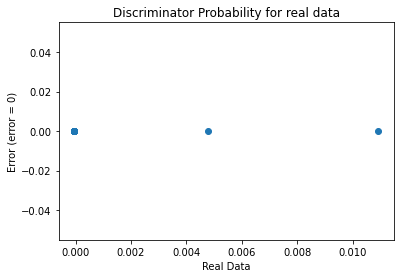

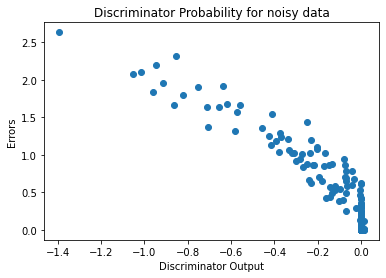

In [19]:
sanityChecks.discProbVsError(real_dataset,disc,device)

## Visualization of trained GAN generator 

In [20]:
for name, param in gen.named_parameters():
    print(name,param)

output.weight Parameter containing:
tensor([[-0.0822,  0.2419,  0.0412,  0.3343,  0.3247,  0.1043,  0.3240,  0.3642,
          0.2216,  0.1773,  0.2154,  0.1635]], requires_grad=True)
output.bias Parameter containing:
tensor([0.0989], requires_grad=True)
